In [1]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from functools import partial

import gymnasium as gym
import numpy as np
import seaborn as sns
import torch as t
from gymnasium.envs.registration import EnvSpec
from matplotlib import pyplot as plt
from rich.pretty import pprint as pp

from libs.bert_sac.models import CleanRLActor, SoftQNetwork
from libs.bert_sac.sac_trainer import AntSAC, AntSACConfig
from libs.bert_sac.utils import make_env

ppe = partial(pp, expand_all=True)

SEED = 99

device = t.device("cuda:0")
t.set_default_device(device)

{'ATT_MASK.shape': torch.Size([27, 27])}

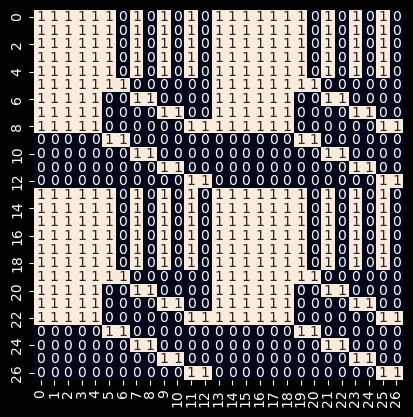

In [3]:
NUM_STRUCT_ELEMENTS = 9

ATT_MASK = t.tensor(
    [
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    ]
)

pp({"ATT_MASK.shape": ATT_MASK.shape})

sns.heatmap(ATT_MASK.cpu(), square=True, cbar=False, annot=True)
plt.show()

In [4]:
critic = SoftQNetwork(ATT_MASK, 27, 9)

In [5]:
obs = t.rand((1, 27))
act = t.rand((1, 9))
obs.shape, act.shape

(torch.Size([1, 27]), torch.Size([1, 9]))

In [6]:
critic(obs, act)

tensor([[0.0083]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [7]:
envs = gym.vector.SyncVectorEnv([make_env("Ant-v4", seed=SEED)])

In [8]:
actor = CleanRLActor(env=envs, att_mask=ATT_MASK)

In [9]:
actor.get_action(obs)[0].shape

torch.Size([1, 8])

In [10]:
sac_config = AntSACConfig(n_legs=4, seed=SEED, checkpoint_frequency=1000)

In [11]:
sac = AntSAC(
    actor_net=CleanRLActor,
    critic_net=SoftQNetwork,
    envs=envs,
    device=device,
    attention_mask=ATT_MASK,
    config=sac_config,
    artifact_path="./artifacts"
)

In [12]:
# import threading


# def scream(ou: str):
#     print("start screaming", ou * 3)
#     sac.train(10_000)
#     print("screamed")
# th = threading.Thread(target=scream, args=("MEW",))
# th.start()

In [18]:
sac.save_checkpoint(sac.global_step)

In [17]:
sac.load_from_checkpoint("artifacts/checkpoints/Ant-v4__99__20240528-230217.tar")

In [14]:
cpt = t.load("artifacts/checkpoints/Ant-v4__99__20240528-230217.tar")

In [16]:
cpt.step

5601

In [18]:
sac.global_step

0

In [17]:
import warnings

warnings.filterwarnings("ignore")

sac.train(25_000)

  0%|          | 0/21318 [00:00<?, ?it/s]

  9%|▉         | 1919/21318 [01:08<11:30, 28.09it/s]  


KeyboardInterrupt: 